# Hierarchical Ar(1) on a Grid Test with compositional score matching

In this notebook, we will test the compositional score matching on a hierarchical problem defined on a grid.
- The observations are on grid with `n_grid` x `n_grid` points.
- The global parameters are the same for all grid points with hyper-priors:
$$ \alpha \sim \mathcal{N}(0, 1) \quad
  \mu_\beta \sim \mathcal{N}(0, 1) \quad
  \log\text{std}_\beta \sim \mathcal{N}(0, 1);$$

- The local parameters are different for each grid point
$$ \eta_{i,j}^\text{raw} \sim \mathcal{N}(0, I), \qquad \eta_{i,j} = 2\operatorname{sigmoid}(\beta + \sigma\cdot\eta_{i,j}^\text{raw})-1$$

-  In each grid point, we have a time series of `T` observations.
$$ y_{i,j} \sim \mathcal{N}(\alpha + \eta_{i,j}y_{i,j-1}, 0.1 I), y_{i,0} \sim \mathcal{N}(0, 0.1 I)$$
- We observe $T=5$ time points for each grid point. We can also amortize over the time dimension.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import optuna

os.environ['KERAS_BACKEND'] = 'torch'
from bayesflow import diagnostics

from torch.utils.data import DataLoader

from diffusion_model import HierarchicalScoreModel, SDE, euler_maruyama_sampling, adaptive_sampling, train_score_model
from diffusion_model.helper_networks import GaussianFourierProjection, ShallowSet, GRUEncoder
from problems.ar1_grid import AR1GridProblem, Prior
from problems import plot_shrinkage, visualize_simulation_output

/Users/jonas.arruda/miniconda/envs/hierarchical-score-matching/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).


In [2]:
torch_device = torch.device("mps")

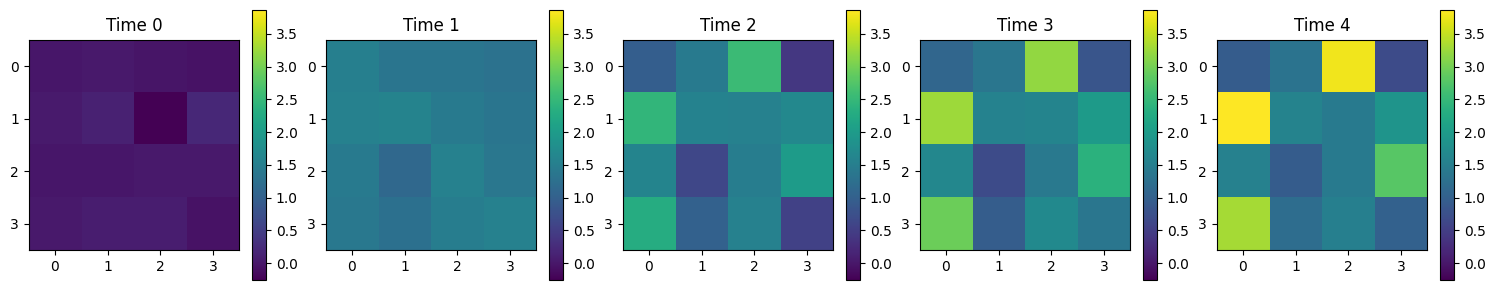

In [3]:
prior = Prior()

# test the simulator
sim_test = prior.sample(1, n_local_samples=16, get_grid=True)['data'][0]
visualize_simulation_output(sim_test)

In [14]:
batch_size = 128
number_of_obs = 1#[1, 4, 8, 16, 64, 128]  # or a list
max_number_of_obs = number_of_obs if isinstance(number_of_obs, int) else max(number_of_obs)
current_sde = SDE(
    kernel_type=['variance_preserving', 'sub_variance_preserving'][0],
    noise_schedule=['linear', 'cosine', 'flow_matching'][1]
)

dataset = AR1GridProblem(
    n_data=10000,
    prior=prior,
    sde=current_sde,
    online_learning=True,
    number_of_obs=number_of_obs,
    amortize_time=False,
    as_set=True
)

dataset_valid = AR1GridProblem(
    n_data=1000,
    prior=prior,
    sde=current_sde,
    number_of_obs=number_of_obs,
    as_set=True,
)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

for test in dataloader:
    print(test[4].shape)
    break

Kernel type: variance_preserving, noise schedule: cosine
t_min: 0.00035210439818911254, t_max: 0.999647855758667
alpha, sigma: (tensor(1.0000), tensor(0.0006)) (tensor(0.0006), tensor(1.0000))
torch.Size([128, 5])


In [15]:
# Define diffusion model
global_summary_dim = 5
global_summary_net = ShallowSet(dim_input=5, dim_output=global_summary_dim, dim_hidden=128)
#local_summary_net = GRUEncoder(input_size=1, summary_dim=5, num_layers=1, hidden_size=16, dropout=0)

time_dim = 8
time_embedding_local = nn.Sequential(
    GaussianFourierProjection(time_dim),
    nn.Linear(time_dim, time_dim),
    nn.Mish()
)
time_embedding_global = nn.Sequential(
    GaussianFourierProjection(time_dim),
    nn.Linear(time_dim, time_dim),
    nn.Mish()
)

score_model = HierarchicalScoreModel(
    input_dim_theta_global=prior.n_params_global,
    input_dim_theta_local=prior.n_params_local,
    input_dim_x_global=global_summary_dim,
    input_dim_x_local=global_summary_dim,
    #summary_net=local_summary_net,
    global_summary_net=global_summary_net if isinstance(number_of_obs, list) else None,
    time_embedding_local=time_embedding_local,
    time_embedding_global=time_embedding_global,
    hidden_dim=[256, 512][0],
    n_blocks=[5,6][0],
    dropout_rate=0.1,
    max_number_of_obs=max_number_of_obs,
    prediction_type=['score', 'e', 'x', 'v'][3],
    sde=current_sde,
    weighting_type=[None, 'likelihood_weighting', 'flow_matching', 'sigmoid'][1],
    prior=prior,
    name_prefix=f'ar1_3_{max_number_of_obs}',
    #name_prefix=f'ar1_GRU_',
)

# make dir for plots
if not os.path.exists(f"plots/{score_model.name}"):
    os.makedirs(f"plots/{score_model.name}")

+--------------------------------------+------------+
|               Modules                | Parameters |
+--------------------------------------+------------+
|        time_embedding.0.scale        |     1      |
|       time_embedding.1.weight        |     64     |
|        time_embedding.1.bias         |     8      |
|   blocks.res_blocks.0.dense.weight   |    4096    |
|    blocks.res_blocks.0.dense.bias    |    256     |
| blocks.res_blocks.0.projector.weight |    4096    |
|   blocks.res_blocks.1.dense.weight   |   65536    |
|    blocks.res_blocks.1.dense.bias    |    256     |
|   blocks.res_blocks.2.dense.weight   |   65536    |
|    blocks.res_blocks.2.dense.bias    |    256     |
|   blocks.res_blocks.3.dense.weight   |   65536    |
|    blocks.res_blocks.3.dense.bias    |    256     |
|   blocks.res_blocks.4.dense.weight   |   65536    |
|    blocks.res_blocks.4.dense.bias    |    256     |
|    final_projection_linear.weight    |    768     |
|     final_projection_linea

In [6]:
# train model
loss_history = train_score_model(score_model, dataloader, dataloader_valid=dataloader_valid, hierarchical=True,
                                              epochs=3000, device=torch_device)
score_model.eval()
torch.save(score_model.state_dict(), f"models/{score_model.name}.pt")

# plot loss history
plt.figure(figsize=(16, 4), tight_layout=True)
plt.plot(loss_history[:, 0], label='Training', color="#132a70", lw=2.0, alpha=0.9)
plt.plot(loss_history[:, 1], label='Validation', linestyle="--", marker="o", color='black')
plt.grid(alpha=0.5)
plt.xlabel('Training epoch #')
plt.ylabel('Value')
plt.legend()
plt.savefig(f'plots/{score_model.name}/loss_training.png')

Training v-model for 3000 epochs with learning rate 0.0005 and likelihood_weighting weighting.


KeyboardInterrupt: 

In [16]:
score_model.load_state_dict(torch.load(f"models/{score_model.name}.pt",
                                       map_location=torch_device, weights_only=True))
score_model.eval();

# Validation

In [29]:
n_grid = 2#512
#np.random.seed(0)
prior_dict = prior.sample(batch_size=100, n_local_samples=n_grid*n_grid)

valid_prior_global, valid_prior_local, valid_data = prior_dict['global_params'], prior_dict['local_params'], prior_dict['data']
n_post_samples = 300
global_param_names = prior.global_param_names
local_param_names = prior.get_local_param_names(n_grid*n_grid)
#score_model.current_number_of_obs = 1 # we can choose here, how many observations are passed together through the score

#score_model.current_number_of_obs = 1
#valid_data = valid_data.reshape(100, n_grid*n_grid, 5, 1)
print(valid_data.shape, score_model.current_number_of_obs)

torch.Size([100, 4, 5]) 1


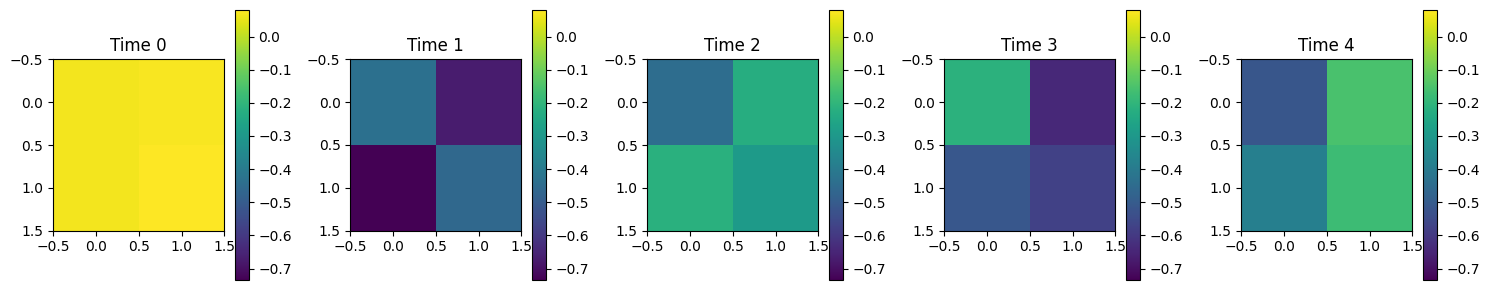

In [30]:
visualize_simulation_output(prior.normalize_data(valid_data[0]).reshape(5, n_grid, n_grid))

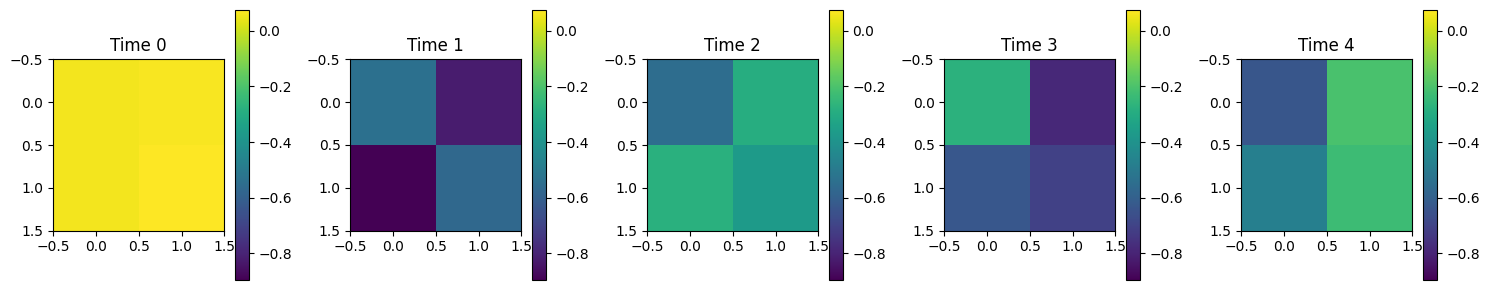

In [31]:
visualize_simulation_output(valid_data[0].reshape(5, n_grid, n_grid))

In [33]:
#t1_value = 1e-8 #0.13694009343501426
#t0_value = 1e-2 #e-2
t1_value = 0.044240666535491316 #0.13694009343501426
t0_value = 1

#{'t1_value': 0.044240666535491316, 's_shift_cosine': 4.960568548054871, 'tau_1': 0.9958869789363028, 'delta_tau_2': 0.12817031370179582, 'noise_scale': 1.3480710136773473, 'mixing_factor': 0.3577859411856741, 'diffusion_steps': 851}


def damping_factor(t):
    #if t.ndim == 0:
    #    #print(t)
    #    val = -np.log(t0_value / (t1_value * np.array([1., 0.1, 0.1], dtype=np.float32)) )
    #    out = t0_value * torch.exp(torch.tensor(val).to(t.device) * 3*t)
    #    print(1/torch.sqrt(out))
    #else:
    val = -np.log(t0_value / (t1_value * np.array([1., 1., 1.], dtype=np.float32)) )
    out = t0_value * torch.exp(torch.tensor(val).to(t.device) * 3*t)
    return out

sampling_arg = {
    'size': 4,
    #'damping_factor': lambda t: (1-torch.ones_like(t)) * 1e-7 + 2e-4,
    #'damping_factor': lambda t: t0_value * torch.exp(-np.log(t0_value / t1_value) * 2*t),
    #'damping_factor': damping_factor,
    'noisy_condition': {
        'apply': False,
        'noise_scale': 1.,
        'tau_1': 1.,
        'tau_2': 1.,
        'mixing_factor': 1.
    },
    'MC-dropout': False
}
score_model.sde.s_shift_cosine = 0#3.71213313557092-2
#score_model.sde.s_shift_cosine = 4.960568548054871

In [34]:
posterior_global_samples_valid = euler_maruyama_sampling(score_model, valid_data,
                                                         n_post_samples=n_post_samples, #ampling_arg=sampling_arg,
                                                         #sampling_arg={'size': 1},
                                                         diffusion_steps=500, device=torch_device, verbose=True)

# posterior_global_samples_valid = adaptive_sampling(score_model, valid_data,
#                                                    n_post_samples=n_post_samples, sampling_arg=sampling_arg,
#                                                    run_sampling_in_parallel=False, device=torch_device, verbose=True)

100%|██████████| 500/500 [00:47<00:00, 10.45it/s]


RMSE: [0.01784067 0.17181347 0.21662241]
ECDF: [0.10657895 0.22605263 0.14210526]


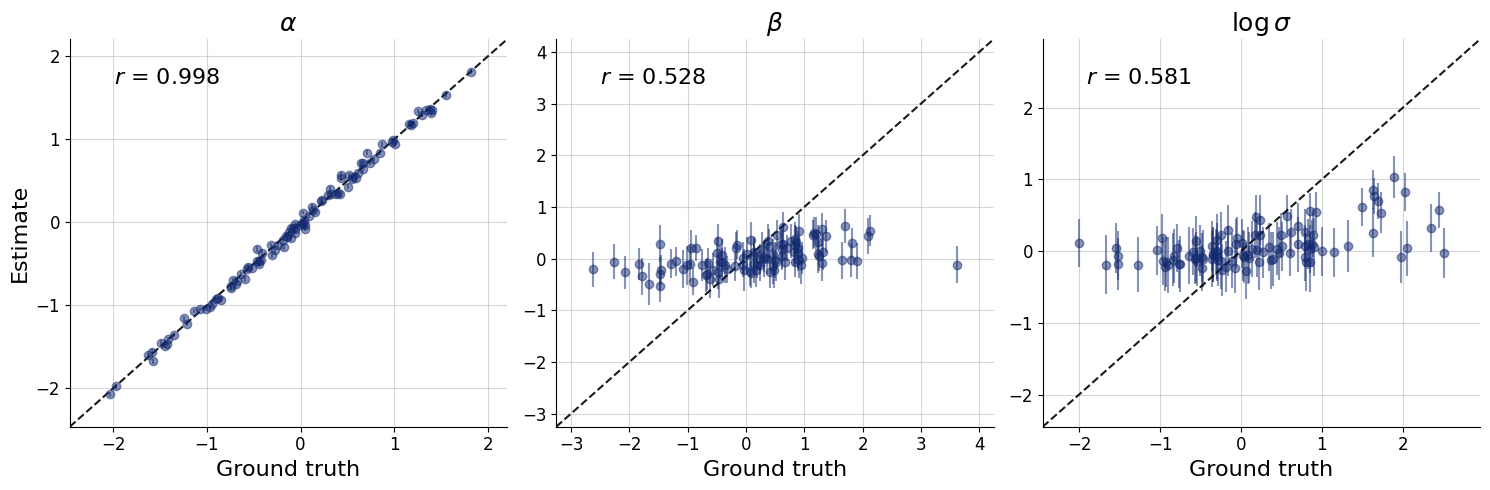

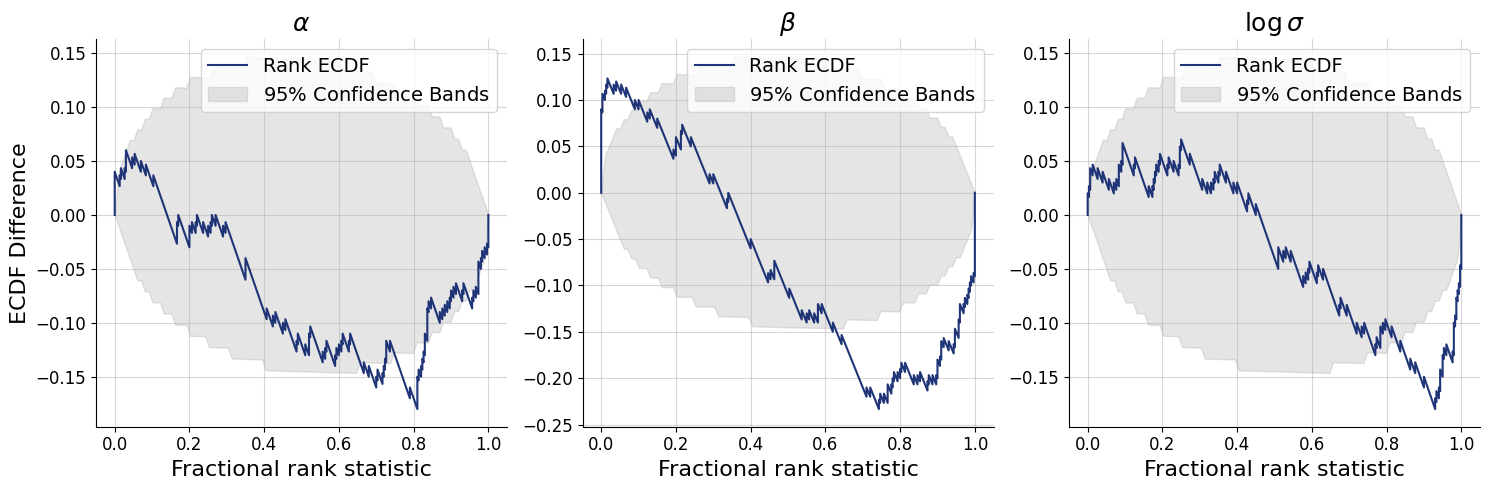

In [35]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=global_param_names)
print('RMSE:', diagnostics.root_mean_squared_error(posterior_global_samples_valid, np.array(valid_prior_global))['values'])
#fig.savefig(f'plots/{score_model.name}/recovery_n_grid_{n_grid}.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                                   difference=True, variable_names=global_param_names)
print('ECDF:', diagnostics.calibration_error(posterior_global_samples_valid, np.array(valid_prior_global))['values'])
#fig.savefig(f'plots/{score_model.name}/ecdf_n_grid_{n_grid}.png')

In [ ]:
mini_batch_size = 8
t1_value = 1e-7# /( (n_grid*n_grid) //score_model.current_number_of_obs)
t0_value = 1
sampling_arg = {
    'size': mini_batch_size,
    'damping_factor': lambda t: t0_value * torch.exp(-np.log(t0_value / t1_value) * 2*t),
    #'noisy_condition': {
    #    'apply': False,
    #    'noise_scale': 1.,
    #    'tau_1': 0.6,
    #    'tau_2': 0.8,
    #    'mixing_factor': 1.
    #}
}
#plt.plot(torch.linspace(0, 1, 100), sampling_arg['damping_factor'](torch.linspace(0, 1, 100)))
#plt.show()
score_model.sde.s_shift_cosine = 10

t0_value, t1_value

In [ ]:
# posterior_global_samples_valid, step_list = adaptive_sampling(score_model, valid_data,
#                                                               obs_n_time_steps=obs_n_time_steps,
#                                                          n_post_samples=100, #max_evals=2000,
#                                                          sampling_arg=sampling_arg, run_sampling_in_parallel=False,
#                                                          device=torch_device, verbose=True, return_steps=True)

posterior_global_samples_valid = euler_maruyama_sampling(score_model, valid_data,
                                                         n_post_samples=n_post_samples,
                                                         sampling_arg=sampling_arg,
                                                         diffusion_steps=10, device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=global_param_names)
print('RMSE:', diagnostics.root_mean_squared_error(posterior_global_samples_valid, np.array(valid_prior_global))['values'])
#fig.savefig(f'plots/{score_model.name}/recovery_global_euler_sub_sampler.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, variable_names=global_param_names)
print('ECDF:', diagnostics.calibration_error(posterior_global_samples_valid, np.array(valid_prior_global))['values'])
#fig.savefig(f'plots/{score_model.name}/ecdf_global_euler_sub_sampler.png')

In [ ]:
posterior_global_samples_valid = adaptive_sampling(score_model, valid_data,
                                                   n_post_samples=n_post_samples,
                                                   #sampling_arg=sampling_arg,
                                                   run_sampling_in_parallel=False,
                                                   device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=global_param_names)
fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, variable_names=global_param_names)

In [ ]:
conditions_global = (np.median(posterior_global_samples_valid, axis=0), posterior_global_samples_valid)[1]
posterior_local_samples_valid = euler_maruyama_sampling(score_model, valid_data[:, :12],
                                                        conditions=conditions_global,
                                                        n_post_samples=n_post_samples,
                                                        diffusion_steps=100, device=torch_device, verbose=True)

posterior_local_samples_valid = score_model.prior.transform_local_params(posterior_local_samples_valid)

In [ ]:
diagnostics.recovery(posterior_local_samples_valid.reshape(valid_data.shape[0], n_post_samples, -1),
                          np.array(valid_prior_local)[:, :12],
                          variable_names=local_param_names[:12]);

In [ ]:
valid_id = 7
print('Data')
visualize_simulation_output(valid_data[valid_id])
print('Global Estimates')
print('mu:', np.median(posterior_global_samples_valid[valid_id, :, 1]), np.std(posterior_global_samples_valid[valid_id, :, 1]))
print('log sigma:', np.median(posterior_global_samples_valid[valid_id, :, 2]), np.std(posterior_global_samples_valid[valid_id, :, 2]))
print('True')
print('mu:', valid_prior_global[valid_id][1].item())
print('log sigma:', valid_prior_global[valid_id][2].item())

In [ ]:
local_p_posterior = posterior_local_samples_valid[valid_id]
local_p_true = valid_prior_local[valid_id]

med = np.median(local_p_posterior, axis=0).flatten()
std = np.std(local_p_posterior, axis=0).flatten()
error = (med-local_p_true.numpy())**2
print(error.sum())
visualize_simulation_output(np.stack((med, local_p_true)).T,
                            title_prefix=['Posterior Median', 'True'])

visualize_simulation_output(np.stack((std, error)).T, title_prefix=['Uncertainty', 'Error'], same_scale=False)


plt.figure(figsize=(4, 4), tight_layout=True)
plt.errorbar(x=local_p_true.flatten(), y=med.flatten(), yerr=1.96*std.flatten(), fmt='o')
plt.plot([np.min(med), np.max(med)], [np.min(med), np.max(med)], 'k--')
#plt.axhline(np.median(posterior_global_samples_valid[valid_id], axis=0)[1], color='red', linestyle='--',
#            label='Global posterior mean', alpha=0.75)
plt.ylabel('Prediction')
plt.xlabel('True')
#plt.legend()
plt.show()

# Compare to STAN

In [ ]:
N = 32*32
global_posterior_stan = np.load(f'problems/ar1/global_posterior_{N}.npy')#[:, -100:]
local_posterior_stan = np.load(f'problems/ar1/local_posterior_{N}.npy')#[:, -100:]
true_global = np.load(f'problems/ar1/true_global_{N}.npy')
true_local = np.load(f'problems/ar1/true_local_{N}.npy')

n_grid_stan = int(np.sqrt(true_local.shape[1]))

test_data = []
for g, l in zip(true_global, true_local):
    sim_dict = {'alpha': g[0],
                'beta': l}
    td = prior.simulator(sim_dict)['observable']
    test_data.append(td.reshape(1, n_grid_stan*n_grid_stan, 5))
test_data = np.concatenate(test_data)

n_obs = n_grid_stan*n_grid_stan
batch_size = test_data.shape[0]
n_post_samples = 300

print(n_grid_stan*n_grid_stan, test_data.shape)

In [ ]:
def objective(trial):
    print(trial.number)
    t1_value = trial.suggest_float('t1_value', 0.01, 0.2)
    s_shift_cosine = trial.suggest_float('s_shift_cosine', 0, 5)
    tau1 = trial.suggest_float('tau_1', 0.5, 1.)
    tau2 = min(tau1 + trial.suggest_float('delta_tau_2', 0, 0.5), 1.)
    noise_scale = trial.suggest_float('noise_scale', 0.1, 2.)
    mixing_factor = trial.suggest_float('mixing_factor', 0, 1.)
    diffusion_steps = trial.suggest_int('diffusion_steps', 500, 1000)

    t0_value = 1
    sampling_arg = {
        'size': 1,
        'damping_factor': lambda t: t0_value * torch.exp(-np.log(t0_value / t1_value) * 2 * t),
        'noisy_condition': {
            'apply': True,
            'noise_scale': noise_scale,
            'tau_1': tau1,
            'tau_2': tau2,
            'mixing_factor': mixing_factor
        },
    }
    score_model.sde.s_shift_cosine = s_shift_cosine

    test_global_samples = euler_maruyama_sampling(score_model, test_data,
                                                       n_post_samples=n_post_samples,
                                                       sampling_arg=sampling_arg,
                                                       diffusion_steps=diffusion_steps,
                                                       device=torch_device, verbose=False)

    c_error = diagnostics.calibration_error(test_global_samples, true_global)['values'].mean()
    rmse = diagnostics.root_mean_squared_error(test_global_samples, true_global)['values'].mean()
    return rmse + c_error

study = optuna.create_study()
study.optimize(objective, n_trials=2)
#print(study.best_params)

study_best_params = {'t1_value': 0.13694009343501426, #0.5*0.3994890029993266,
                     's_shift_cosine': 3.712133135570926-0.5, #4.190800555472762-2,
                     'tau_1': 0.6, 'delta_tau_2': 0.2}

In [ ]:
def damping_factor(t):
    val = -np.log(t0_value / (t1_value * np.array([1, 1.5, 1.5], dtype=np.float32)) )
    return t0_value * torch.exp(torch.tensor(val).to(t.device) * 2*t)

In [ ]:
t0_value, t1_value = 1, study_best_params['t1_value']
sampling_arg = {
    'size': 1,
    'damping_factor': lambda t: t0_value * torch.exp(-np.log(t0_value / t1_value) * 2*t),
    #'damping_factor': damping_factor,
    'noisy_condition': {
        'apply': True,
        'noise_scale': 2.,
        'tau_1': 0.8, #study_best_params['tau_1'],
        'tau_2': 0.9, #min(study_best_params['tau_1'] + study_best_params['delta_tau_2'], 1),
        'mixing_factor': 0.4
    },
    'MC-dropout': False
}
global_param_names = prior.global_param_names
local_param_names = prior.get_local_param_names(n_grid_stan*n_grid_stan)
param_names_stan = ['STAN '+ p for p in global_param_names]
score_model.sde.s_shift_cosine = study_best_params['s_shift_cosine']

print(sampling_arg)

In [ ]:
#score_model.current_number_of_obs = 64
# posterior_global_samples_test = adaptive_sampling(score_model, test_data,
#                                                     n_post_samples=n_post_samples,
#                                                     sampling_arg=sampling_arg,
#                                                     run_sampling_in_parallel=False,
#                                                     device=torch_device, verbose=True)

posterior_global_samples_test = euler_maruyama_sampling(score_model, test_data,
                                                   n_post_samples=n_post_samples,
                                                   sampling_arg=sampling_arg,
                                                   diffusion_steps=600,
                                                   device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_global_samples_test, true_global, variable_names=global_param_names)
#fig.savefig(f'plots/{score_model.name}/recovery_global_ours.png')
print('RMSE:', diagnostics.root_mean_squared_error(posterior_global_samples_test, true_global)['values'].mean())
#fig = diagnostics.recovery(posterior_global_samples_test, np.median(global_posterior_stan, axis=1),
#                     variable_names=global_param_names, xlabel='STAN Median Estimate')
#fig.savefig(f'plots/{score_model.name}/recovery_global_ours_vs_STAN.png')
fig = diagnostics.recovery(global_posterior_stan, true_global, variable_names=param_names_stan)
#fig.savefig(f'plots/{score_model.name}/recovery_global_STAN.png')
print('RMSE STAN:', diagnostics.root_mean_squared_error(global_posterior_stan, true_global)['values'].mean())

In [ ]:
fig = diagnostics.calibration_ecdf(posterior_global_samples_test, true_global, difference=True,
                             variable_names=global_param_names)
#fig.savefig(f'plots/{score_model.name}/ecdf_global_ours.png')
print('ECDF:', diagnostics.calibration_error(posterior_global_samples_test, true_global)['values'].mean())

fig = diagnostics.calibration_ecdf(global_posterior_stan, true_global, difference=True, variable_names=param_names_stan)
#fig.savefig(f'plots/{score_model.name}/ecdf_global_STAN.png')
print('ECDF STAN:', diagnostics.calibration_error(global_posterior_stan, true_global)['values'].mean())

In [ ]:
score_model.sde.s_shift_cosine = 0
score_model.current_number_of_obs = 1
posterior_local_samples_test = euler_maruyama_sampling(score_model, test_data[:, :12],
                                                       n_post_samples=n_post_samples,
                                                       conditions=posterior_global_samples_test,
                                                       #conditions=global_posterior_stan[:, :n_post_samples],
                                                       #run_sampling_in_parallel=False,
                                                       diffusion_steps=200,
                                                       device=torch_device, verbose=True)

posterior_local_samples_test = score_model.prior.transform_local_params(posterior_local_samples_test)

In [ ]:
global_var = np.exp(np.median(posterior_global_samples_test, axis=1)[:, 1])[:, np.newaxis] ** 2
shrinkage = 1-np.var(np.median(posterior_local_samples_test, axis=1), axis=1)/global_var

global_var_stan = np.exp(np.median(global_posterior_stan, axis=1)[:, 1])**2
shrinkage_stan = 1-np.var(np.median(local_posterior_stan, axis=1), axis=1)/global_var_stan

true_var = np.exp(true_global)[:, 1]**2
shrinkage_true = 1-np.var(true_local, axis=1)/true_var

s_order = np.argsort(shrinkage_true)
shrinkage = shrinkage.flatten()[s_order]
shrinkage_stan = shrinkage_stan.flatten()[s_order]
shrinkage_true = shrinkage_true[s_order]

min_s = -10
shrinkage[shrinkage < min_s] = min_s
shrinkage_stan[shrinkage_stan < min_s] = min_s
shrinkage_true[shrinkage_true < min_s] = min_s

plt.title('Shrinkage')
plt.plot(shrinkage, label='score', alpha=0.75)
plt.plot(shrinkage_stan, label='STAN', alpha=0.75)
plt.plot(shrinkage_true, label='true', alpha=0.75)
plt.legend()
plt.show()

print('Correlation shrinkage score and STAN:', np.corrcoef(shrinkage, shrinkage_stan)[0, 1])
print('Correlation shrinkage true and score:', np.corrcoef(shrinkage_true, shrinkage)[0, 1])
print('Correlation shrinkage true and STAN:', np.corrcoef(shrinkage_true, shrinkage_stan)[0, 1])

print(f"Score shrinkage < STAN shrinkage: {(shrinkage < shrinkage_stan).sum() / shrinkage.shape[0]*100}%")

In [ ]:
diagnostics.recovery(posterior_local_samples_test.reshape(test_data.shape[0], n_post_samples, -1)[:, :, :12],
                     true_local[:, :12],
                     variable_names=local_param_names[:12])
#fig.savefig(f'plots/{score_model.name}/recovery_local_ours.png')
diagnostics.recovery(local_posterior_stan[:, :, :12], true_local[:, :12], variable_names=local_param_names[:12]);

In [ ]:
fig = diagnostics.recovery(posterior_local_samples_test.reshape(test_data.shape[0], n_post_samples, -1)[:, :, :12],
                     np.median(local_posterior_stan[:, :, :12], axis=1),
                           xlabel='STAN Median Estimate', variable_names=local_param_names[:12])
#fig.savefig(f'plots/{score_model.name}/recovery_local_ours_vs_STAN.png')

In [ ]:
posterior_local_samples_test.reshape(test_data.shape[0], n_post_samples, -1)

plot_shrinkage(posterior_global_samples_test[:12, :, 1:], posterior_local_samples_test[..., np.newaxis][:12],
               min_max=(-10,10))

In [ ]:
plot_shrinkage(global_posterior_stan[:12, :100, 1:], local_posterior_stan[..., np.newaxis][:12], min_max=(-10,10))